In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Load train and test data
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

In [ ]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

# Standardize numerical columns
# scaler_train = StandardScaler()

# X_train[numeric_cols_train.columns] = scaler_train.fit_transform(numeric_cols_train)

# scaler_test = StandardScaler()
# numeric_cols_test = X_test.select_dtypes(include=['number'])
# X_test[numeric_cols_test.columns] = scaler_test.fit_transform(numeric_cols_test)

#### Random UnderSampling

In [4]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

Size of X_train after random undersampling: 80256


#### Smote-NC

In [5]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

print(f'Train data size:{len(X_train_smote)}')
print(f'Fraud proportion in train data: {round(y_train_smote.mean(), 2)}')

Train data size:109440
Fraud proportion in train data: 0.33


### One-Hot Encoding

In [ ]:
# # Apply one-hot encoding on train and test data
# X_train_ohe = pd.get_dummies(X_train_smote, drop_first = True)
# X_test_ohe = pd.get_dummies(X_test, drop_first = True)
# X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

# print(f'Number of columns after one-hot encoding: {len(X_train_ohe.columns)}')

Number of columns after one-hot encoding: 541


### Pipeline with Lasso (training)

In [14]:
numeric_columns = X_train.select_dtypes(include=['number']).columns.tolist()
preprocessor=ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
categorical_columns),
        ('num', MinMaxScaler(), numeric_columns)
    ]
)

In [29]:
# Define the pipeline with Lasso for feature selection followed by RandomForest
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.01))),
    ('classifier', RandomForestClassifier(random_state=123))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [3,5],
    'classifier__max_features': ['sqrt', 10],
    'classifier__max_depth': [3, 5],
    'classifier__criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
cv_lasso_pipe = GridSearchCV(
    estimator=lasso_pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

# Fit the grid search
cv_lasso_pipe.fit(X_train_smote, y_train_smote)

# Get the best model
best_lasso_pipe = cv_lasso_pipe.best_estimator_



Fitting 5 folds for each of 16 candidates, totalling 80 fits


Python(63650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63651) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63652) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63654) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63655) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(63657) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=sqrt, classifier__n_estimators=5; total time=  26.1s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=sqrt, classifier__n_estimators=5; total time=  25.5s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=sqrt, classifier__n_estimators=3; total time=  27.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=sqrt, classifier__n_estimators=3; total time=  33.2s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=sqrt, classifier__n_estimators=3; total time=  33.2s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=sqrt, classifier__n_estimators=3; total time=  33.2s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__max_features=sqrt, classifier__n_estimators=3; total time=  33.0s
[CV] END classifier_


Lasso Pipeline Results:
accuracy: 0.9897934941520468, precision: 0.986289519973351, recall: 0.9909745065789474, f1: 0.9885732760851105
AUC: 0.99


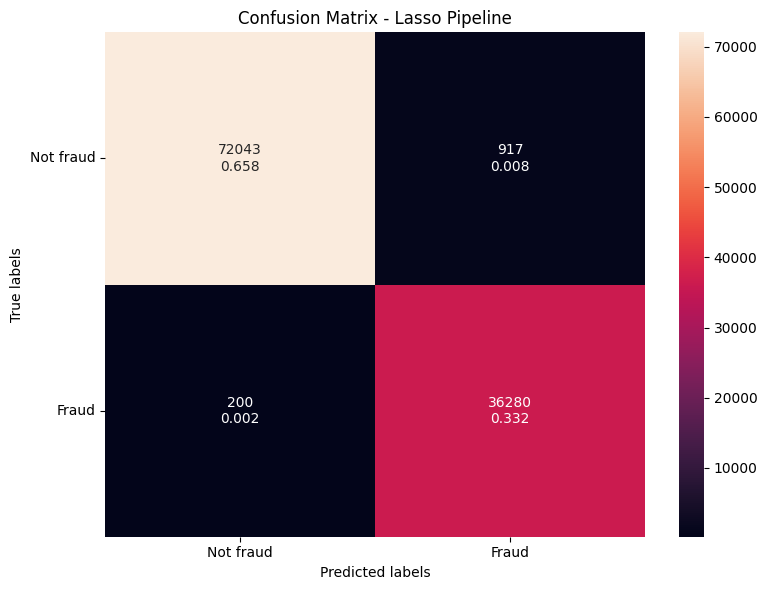

In [30]:
# Evaluate using cross-validation
sk_folds_lasso = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_lasso_pipe = cross_val_predict(best_lasso_pipe, X_train_smote, y_train_smote, cv=sk_folds_lasso)

# Calculate metrics
auc_lasso_pipe = roc_auc_score(y_train_smote, y_pred_lasso_pipe)
print("\nLasso Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_smote, y_pred_lasso_pipe)}, "
      f"precision: {precision_score(y_train_smote, y_pred_lasso_pipe, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_smote, y_pred_lasso_pipe, average='macro')}, "
      f"f1: {f1_score(y_train_smote, y_pred_lasso_pipe, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_lasso_pipe, 2)}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_lasso = confusion_matrix(y_train_smote, y_pred_lasso_pipe)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_lasso.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_lasso.flatten()/np.sum(cm_lasso)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for Lasso Pipeline
ax = plt.subplot()
sns.heatmap(cm_lasso, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Lasso Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()



In [31]:
# Report chosen hyperparameters
print(f'Chosen hyperparameters: {cv_lasso_pipe.best_params_}')

# Get feature names after preprocessing
preprocessor = best_lasso_pipe.named_steps['preprocessor']
preprocessed_features = preprocessor.get_feature_names_out()

# Identify which features were selected
selected_features_mask = best_lasso_pipe.named_steps['feature_selection'].get_support()
selected_features = preprocessed_features[selected_features_mask]  # Use preprocessed_features instead of X_train_smote.columns

# Print selected features 
print("Selected features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

# Print total count
print(f"\nTotal selected features: {len(selected_features)} out of {len(preprocessed_features)}")

# Get feature importances from the classifier
feature_importances = best_lasso_pipe.named_steps['classifier'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

print('\nTop 10 most important features:')
print(importance_df.sort_values(by='Importance', ascending=False)[:10])

Chosen hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 3}
Selected features:
1. num__prev_trans_fraud
2. num__visited_cat

Total selected features: 2 out of 548

Top 10 most important features:
                 Feature  Importance
0  num__prev_trans_fraud    0.808604
1       num__visited_cat    0.191396


In [32]:
print(selected_features)

['num__prev_trans_fraud' 'num__visited_cat']


### Performance on Test Data


Test Data Results:
Accuracy: 0.9848
Precision: 0.5878
Recall: 0.9924
F1 Score: 0.6456
AUC: 0.9924


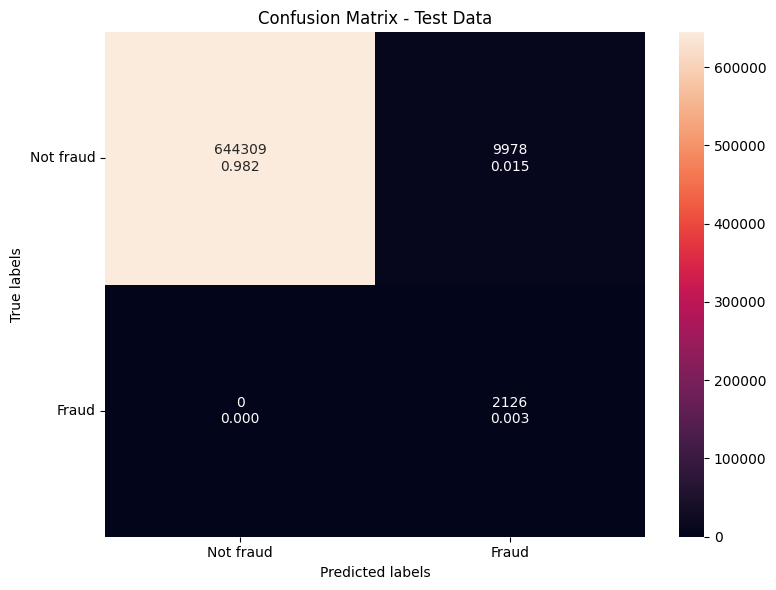

In [33]:
# Use the best model from grid search to predict on test data

y_pred_test = best_lasso_pipe.predict(X_test)

# Calculate evaluation metrics on test data
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='macro', zero_division=0.0)
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=0.0)
test_auc = roc_auc_score(y_test, y_pred_test)

# Print test metrics
print("\nTest Data Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC: {test_auc:.4f}")

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_pred_test)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_test.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_test.flatten()/np.sum(cm_test)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for test data
ax = plt.subplot()
sns.heatmap(cm_test, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Test Data')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

### Manual Run on Test Data

Test Results:
Accuracy: 0.9062
Precision: 0.5166
Recall: 0.9518
F1 Score: 0.5075
AUC: 0.9979


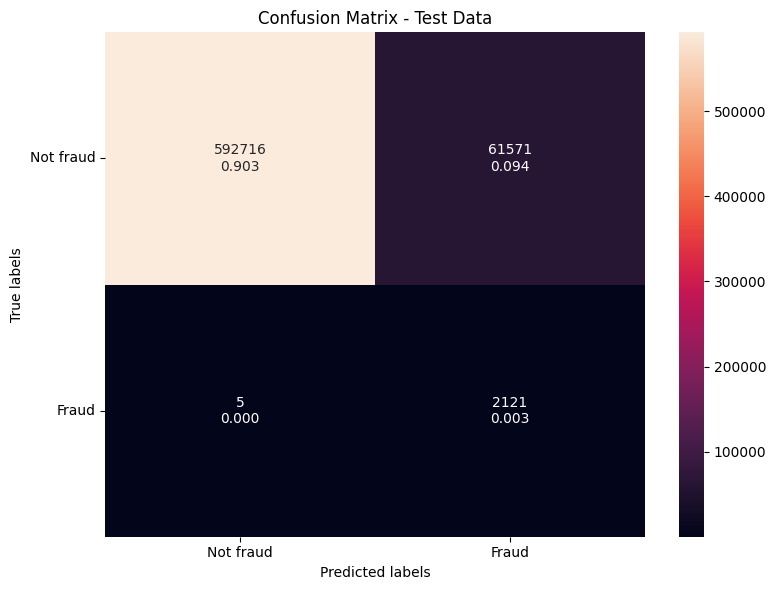


Feature Importance:
                     Feature  Importance
2           prev_trans_fraud    0.381784
7                visited_cat    0.283025
0                        amt    0.132076
4  merchant_prev_trans_fraud    0.095805
3          count_fraud_7days    0.038741
1                       hour    0.035300
6          hourly_risk_score    0.025735
5   merchant_acc_fraud_count    0.006326
8      first_second_purchase    0.001210


In [8]:
selected_features = ['amt', 'hour', 'prev_trans_fraud', 'count_fraud_7days', 
                     'merchant_prev_trans_fraud', 'merchant_acc_fraud_count', 
                     'hourly_risk_score', 'visited_cat', 'first_second_purchase']


X_test_selected_ohe = X_test_ohe[selected_features]

# Create the Random Forest model with your chosen hyperparameters
rf_model = RandomForestClassifier(
    criterion='entropy',
    max_depth=15,
    max_features='sqrt',
    n_estimators=150,
    random_state=123  # using same random state for reproducibility
)

# Train the model on your training data with selected features
rf_model.fit(X_train_ohe[selected_features], y_train_smote)

# Make predictions on test data
y_pred = rf_model.predict(X_test_selected_ohe)
y_pred_proba = rf_model.predict_proba(X_test_selected_ohe)[:, 1]  # Probability of fraud class

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0.0)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0.0)
auc = roc_auc_score(y_test, y_pred_proba)

# Print the results
print("Test Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for test data
ax = plt.subplot()
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Test Data')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

# Display feature importances
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)